Prerequisites are ready.

Training the Neural Network model...


/Users/xinglingao/Documents/machine_learning/venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/xinglingao/Documents/machine_learning/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-16 11:01:54.142193: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shap

Model training complete.

Model Evaluation (Neural Network):
Accuracy: 0.9325
ROC AUC Score: 0.9612

Confusion Matrix:
[[616  13]
 [ 38  88]]


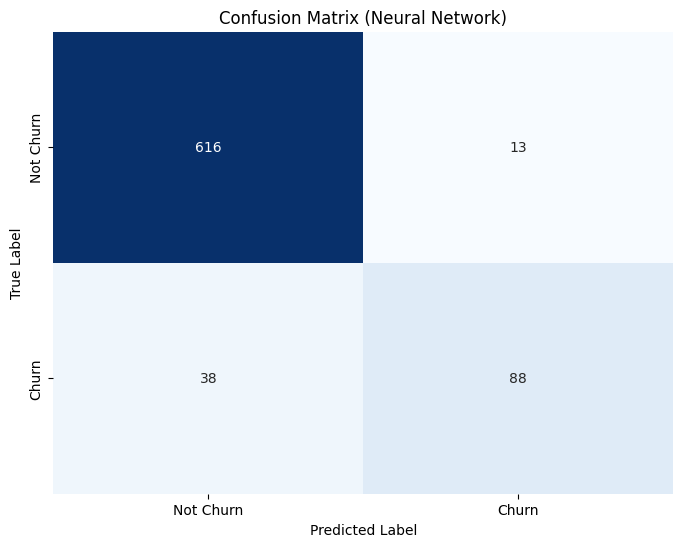


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       629
           1       0.87      0.70      0.78       126

    accuracy                           0.93       755
   macro avg       0.91      0.84      0.87       755
weighted avg       0.93      0.93      0.93       755


Calculating Feature Importance for Neural Network (using Permutation Importance)...
Note: This can be slow as it involves re-evaluating the model multiple times.

Feature Importance (Permutation Method):
                        Feature  Importance
0                        Tenure    0.100530
12                     Complain    0.041854
8              PreferedOrderCat    0.041060
4          PreferredPaymentMode    0.040927
11              NumberOfAddress    0.040132
3               WarehouseToHome    0.027682
9             SatisfactionScore    0.027682
16            DaySinceLastOrder    0.024106
7      NumberOfDeviceRegistered    0.022517
15  

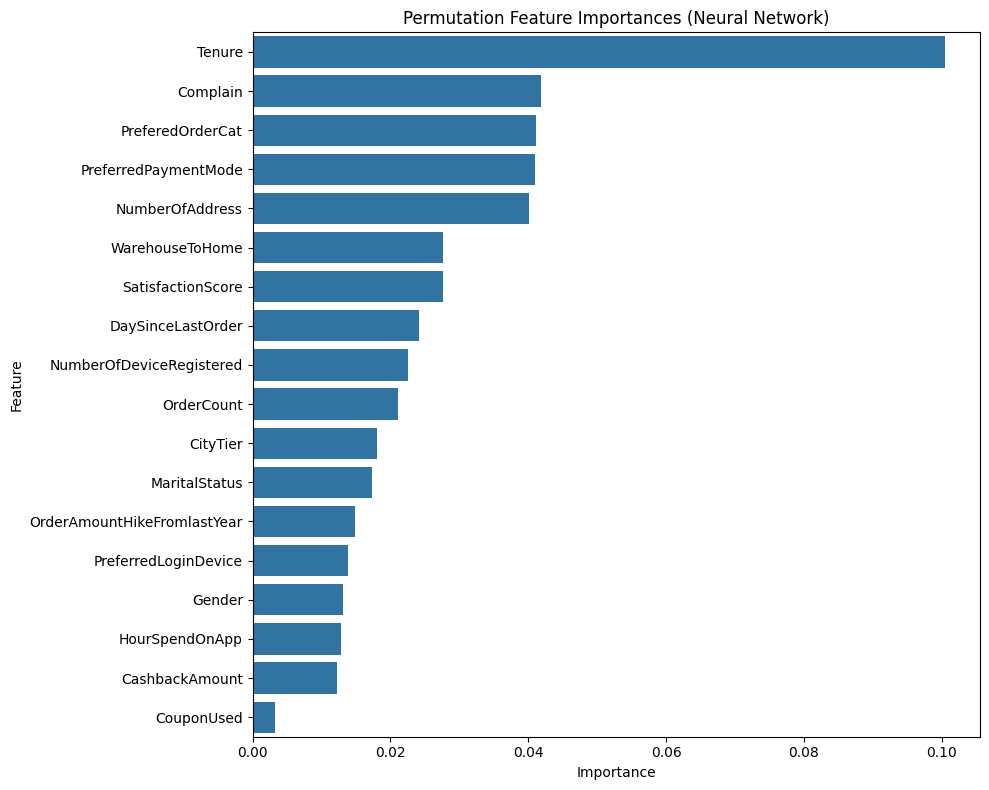

In [1]:


# Prerequisite imports from your original Cell 1 (plus new ones for NN)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# New imports for the Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.inspection import permutation_importance


# In a real notebook, you would not re-run this part.
try:
    df = pd.read_csv('ECommerce_Churn_Data.csv')

    # Basic cleaning from original script
    if 'CustomerID' in df.columns:
        df = df.drop('CustomerID', axis=1)
    df.dropna(inplace=True) # Simple drop for reproducibility, use your imputation if preferred

    target_column = 'Churn'
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include='object').columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
        ],
        remainder='passthrough'
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print("Prerequisites are ready.")
except FileNotFoundError:
    print("Error: The dataset file 'ECommerce_Churn_Data.csv' was not found.")
    print("Skipping execution. Please run the data loading cells first.")
    df = pd.DataFrame()


# Cell 5 (NN Version): Create and Train the Neural Network Model
if not df.empty:
    # First, we need to know the input shape for the neural network after preprocessing.
    # We can get this by fitting the preprocessor on the training data.
    X_train_transformed = preprocessor.fit_transform(X_train)
    n_features = X_train_transformed.shape[1]

    # Define a function to create the Keras model. This is required for the KerasClassifier wrapper.
    def create_nn_model(input_dim):
        model = Sequential()
        # Input Layer: Dense with 'relu' activation.
        # The number of neurons (e.g., 64) is a hyperparameter you can tune.
        model.add(Dense(64, input_dim=input_dim, activation='relu'))
        # Dropout layer to prevent overfitting
        model.add(Dropout(0.3))
        # Hidden Layer
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.3))
        # Output Layer: 1 neuron for binary output, 'sigmoid' for probability
        model.add(Dense(1, activation='sigmoid'))
        
        # Compile the model
        # 'adam' is an efficient optimizer, 'binary_crossentropy' is standard for binary classification
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    # Create the Scikit-Learn compatible classifier
    # We pass hyperparameters for training (epochs, batch_size) here.
    # `verbose=0` will hide the training progress for each epoch.
    nn_classifier = KerasClassifier(build_fn=create_nn_model, input_dim=n_features,
                                    epochs=50, batch_size=32, verbose=0, random_state=42)

    # Create the full pipeline
    nn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', nn_classifier)])

    # Train the model
    # Note: The preprocessor is already fit, but the pipeline handles this correctly.
    # For a clean run, we create a new pipeline with an unfitted preprocessor.
    nn_pipeline_to_fit = Pipeline(steps=[('preprocessor', ColumnTransformer(
                                        transformers=[
                                            ('num', StandardScaler(), numerical_features),
                                            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
                                        ], remainder='passthrough')),
                                   ('classifier', nn_classifier)])

    print("\nTraining the Neural Network model...")
    # `fit` will pass data through the preprocessor and then to the Keras model
    history = nn_pipeline_to_fit.fit(X_train, y_train)
    print("Model training complete.")


# Cell 6 (NN Version): Make Predictions and Evaluate the Model
if 'nn_pipeline_to_fit' in locals() and 'X_test' in locals():
    # Make predictions
    y_pred = nn_pipeline_to_fit.predict(X_test)
    y_pred_proba = nn_pipeline_to_fit.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("\nModel Evaluation (Neural Network):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Plotting Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Neural Network)')
    plt.show()

    print("\nClassification Report:")
    print(class_report)


# Cell 7 (NN Version): Feature Importance (using Permutation Importance)
if 'nn_pipeline_to_fit' in locals():
    print("\nCalculating Feature Importance for Neural Network (using Permutation Importance)...")
    print("Note: This can be slow as it involves re-evaluating the model multiple times.")

    # Get feature names after one-hot encoding from the fitted preprocessor
    try:
        ohe_feature_names = nn_pipeline_to_fit.named_steps['preprocessor'] \
                                              .named_transformers_['cat'] \
                                              .get_feature_names_out(categorical_features)
        all_feature_names = numerical_features + list(ohe_feature_names)

        # Calculate permutation importance on the test data
        result = permutation_importance(
            nn_pipeline_to_fit, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
        )

        # Create a DataFrame for feature importance
        perm_importance_df = pd.DataFrame({
            'Feature': X_test.columns, # Use original feature names before transformation
            'Importance': result.importances_mean
        }).sort_values(by='Importance', ascending=False)
        
        # Note: Permutation importance is calculated on original features, not the OHE ones.
        # This gives a more intuitive result (e.g., importance of 'Gender' as a whole).

        print("\nFeature Importance (Permutation Method):")
        print(perm_importance_df)

        # Plot feature importance
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=perm_importance_df)
        plt.title('Permutation Feature Importances (Neural Network)')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"\nCould not display feature importance: {e}")